# <center> **NLP analysis of jokes dataset**

In [1]:
!pip install iplot

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from scipy.stats import norm

from google.colab import drive
import os
import string

import plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api
from torch.nn.utils.rnn import pad_sequence

from functools import partial
import torch   
# from torchtext import data    
import torch.nn as nn
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, random_split, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim

import re
import gc

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import classification_report

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


# Read data: 

In [4]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [5]:
data.head()

,joke,rank
id,,
5tz52q,I hate how you cannot even say black paint any...,1
5tz4dd,What is the difference between a Jew in Nazi G...,0
5tz319,I recently went to America..... ...and being t...,0
5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
5tz1pc,You hear about the University book store worke...,0


In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

joke    0
rank    0
dtype: int64

# VW model

In [9]:
!pip install vowpalwabbit

     |████████████████████████████████| 3.0 MB 4.9 MB/s 


In [19]:
!sudo apt-get install vowpal-wabbit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libvw0
Suggested packages:
  vowpal-wabbit-doc
The following NEW packages will be installed:
  libvw0 vowpal-wabbit
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 797 kB of archives.
After this operation, 3,034 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libvw0 amd64 8.5.0.dfsg1-1 [748 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 vowpal-wabbit amd64 8.5.0.dfsg1-1 [49.1 kB]
Fetched 797 kB in 1s (957 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm 

In [10]:
from vowpalwabbit import pyvw
from sklearn.preprocessing import MultiLabelBinarizer

In [18]:
import re
import pickle

from scipy.sparse import csr_matrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [ ]:
import itertools 
from sklearn.metrics import  confusion_matrix
%config InlineBackend.figure_format = 'retina'

def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

In [44]:
df = data.copy(deep=True)

In [45]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [46]:
df['joke'] = df['joke'].apply(lambda text: remove_punctuation(text))
df.head(1)

,joke,rank
id,,
5tz52q,I hate how you cannot even say black paint any...,1


In [48]:
train_documents, test_documents, train_labels_mult, test_labels_mult = train_test_split(df['joke'],
                                                    df['rank'].values, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [49]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

In [50]:
with open(os.path.join('jokes_train_mult.vw'), 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join('jokes_test_mult.vw'), 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

We train Vowpal Wabbit in multiclass classification mode, passing oaa parameter("one against all"), with number of classes. Also, lets see parameters we can tune and model quality can be very depended on them (more info – in the official Vowpal Wabbit tutorial):

learning rate (-l, 0.5 default) – rate of weight change on every step
learning rate decay (--power_t, 0.5 default) – it is proven by practice, that if learning rate drops along with further steps of stochastic gradient descent, we approach loss minimum better
loss function (--loss_function) – entire training algorithm depends on it. Docs about loss functions
Regularization (-l1) – note, that VW calculates regularization for every object, that why we usually set regularization values small, about  10−20. 
Additionally we can try automatic Vowpal Wabbit parameters tuning with Hyperopt.

In [51]:
!head -5 jokes_train_mult.vw 

1 |text not know what wrong with goldfish was fine when put its cage last night
3 |text sex with teacher year old boy came home all happy his mum asked what did you school today hunny had sex with teacher said calmly the mother began scream and yell and sent him his room until his father got home when the father arrived home the mother said distroutly and close tears talk your sonhe had sex with his teacher today the dad with the big grin his face walked upstairs asked his son what happened school and his son told him had sex with teacher the dad said son proud you going get you that bike you wanted they out and buy the bike and then the dad asked him wanted ride home and the son replied nah dad bum still sore
4 |text joke philosophy professor told philosophers are known have horrible jokes and this one exception just posting this for any philosophers who may may not appreciate john has date tomorrow with pretty girl from his philosophy class nervous fellow and worried about how break 

In [52]:
%%time
!vw --log_multi 5 jokes_train_mult.vw -f jokes_model_mult.vw --loss_function=hinge

final_regressor = jokes_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = jokes_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1       15
0.500000 1.000000            2            2.0        3        1      125
0.750000 1.000000            4            4.0        2        4       12
0.857143 1.000000            8            8.0        1        2       15
0.923077 1.000000           16           16.0        4        1       14
0.708333 0.454545           32           32.0  unknown        2       19
0.750000 0.791667           64           64.0        4        2       41
0.707865 0.658537          128          128.0        1        2        7
0.668508 0.630435          256          256.0        2        2       26
0.693182 0.719298   

In [53]:
!vw -i jokes_model_mult.vw -t -d jokes_test_mult.vw \
-p jokes_test_predictions_mult.txt

only testing
predictions = jokes_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = jokes_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        2        9
    n.a.     n.a.            2            2.0  unknown        2       47
    n.a.     n.a.            4            4.0  unknown        2       12
    n.a.     n.a.            8            8.0  unknown        2       12
    n.a.     n.a.           16           16.0  unknown        2       12
    n.a.     n.a.           32           32.0  unknown        2       10
    n.a.     n.a.           64           64.0  unknown        2       17
    n.a.     n.a.          128          128.0  unknown        2       14
    n.a.     n.a.          256          256.0  unknown        2      191


In [82]:
with open('jokes_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) for label in pred_file.readlines()]

In [81]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.21223152530032763

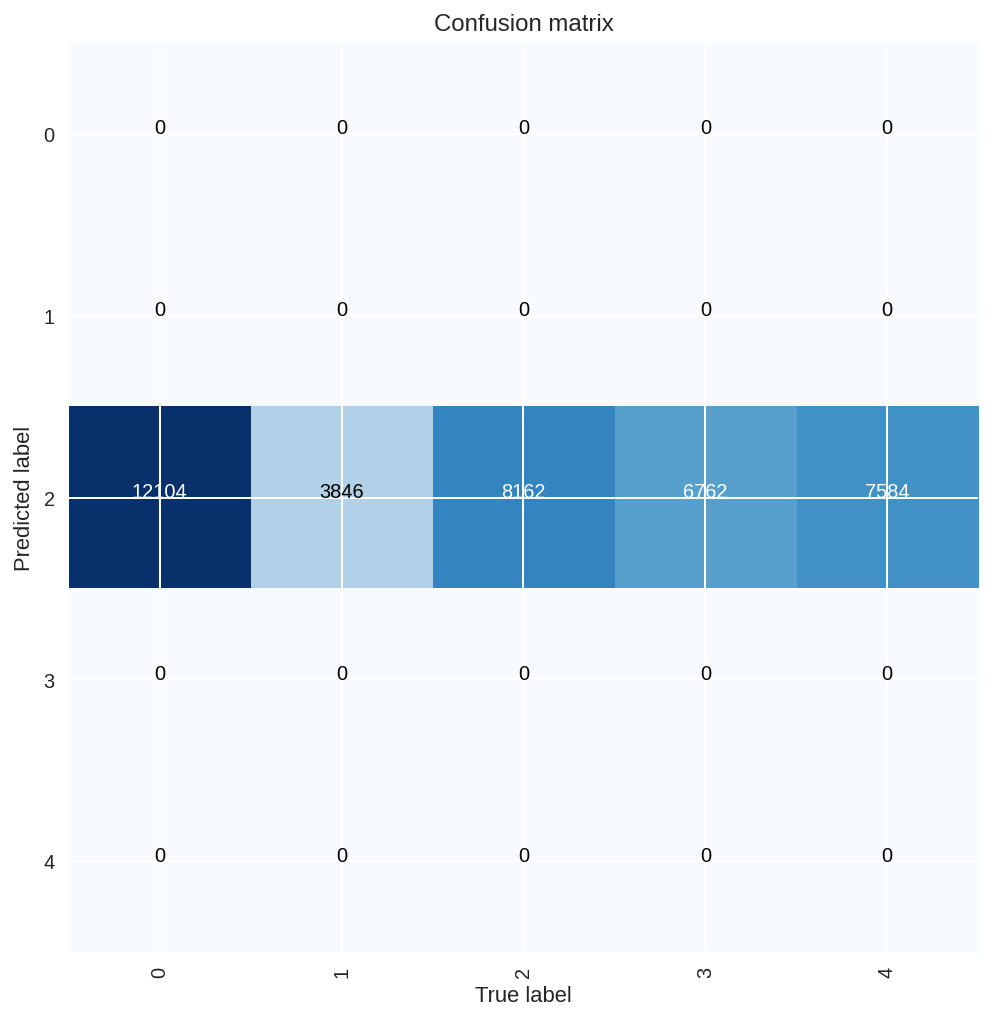

In [83]:
plot_confusion_matrix(actual=test_labels_mult,
                     predicted=test_prediction_mult,
                     classes=[0,1,2,3,4])

In [65]:
# Defining model to be learned
model = pyvw.vw("--csoaa 5 -q UA")

In [68]:
# Online Learning loop
for text, target in zip(train_documents, train_labels_mult):
  inp = to_vw_format(text, target)
  model.learn(inp)

In [75]:
def prediction_accuracy(model):
    # correct = 0
    preds = []
    for text in test_documents:
        inp = to_vw_format(text)
        ans = model.predict(inp)
        preds.append(ans)

    return preds

In [76]:
preds = prediction_accuracy(model)

In [77]:
accuracy_score(test_labels_mult, preds)

0.10000520047844402

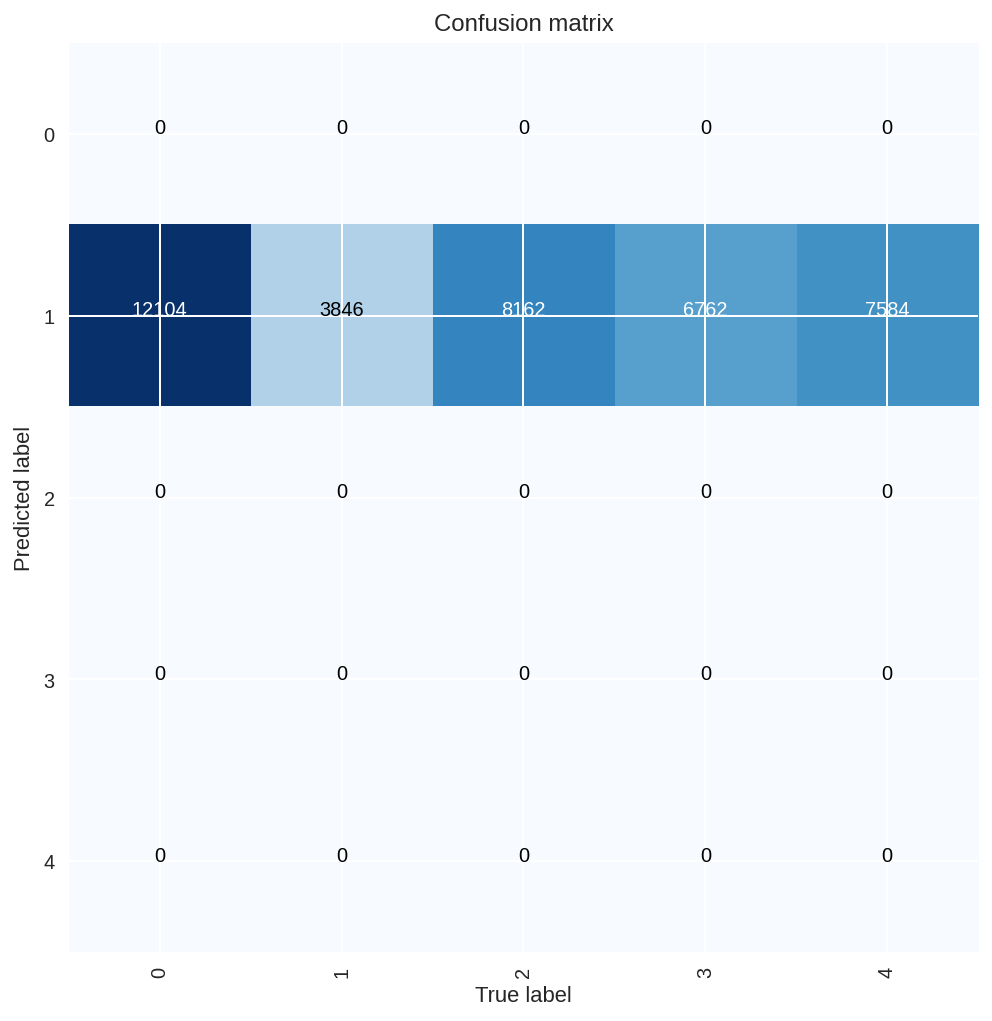

In [80]:
plot_confusion_matrix(actual=test_labels_mult,
                     predicted=preds,
                     classes=[0,1,2,3,4])